In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

C:\Users\Roland\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
labels = [2, 4, 8]

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
selection = np.any([y_test == label for label in labels], axis=0)
X = x_test[selection]
Y = y_test[selection]

X = X.reshape((len(X), -1)) / 255.0
X = (X > 0.5).astype(np.float32)

X_freq = 20 + X*70

In [4]:
def generate_spike_trains(X_freq, T, delta_T = 0.01):
    n_samples = int(np.ceil(T / 0.250))
    sample_steps = int(np.ceil(0.250/delta_T))
    
    n_steps = n_samples * sample_steps
    
    # generate rates
    rates = np.zeros((n_steps, X_freq.shape[1]))
    sample_indices = np.random.randint(0, len(X_freq), size=n_samples)
    for i, sample_index in enumerate(sample_indices):
        rates[i*sample_steps:(i+1)*sample_steps] = X_freq[sample_index]
        
    # now generate the spike trains
    y = np.zeros((n_steps, X_freq.shape[1]))
    for i, rs in enumerate(rates):
        p = np.random.uniform(0.0, 1.0, size=rates.shape[1])
        y[i] = (rs*delta_T > p).astype(np.float32)
        
    return y

In [5]:
X_spikes = generate_spike_trains(X_freq, 1000, delta_T=1e-2)

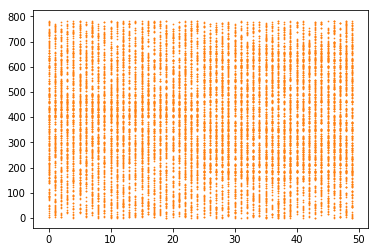

In [14]:
a = 50
for i in range(28*28):
    plt.scatter(np.arange(a)[X_spikes[:a, i] == 1.0], i*np.ones(np.sum(X_spikes[:a, i] == 1.0)), s=0.5, c='C1')
plt.show()

In [236]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dirac(x):
    return np.isclose(x, 0).astype(np.float32)

In [237]:
class Network:
    def __init__(self, n_inputs, n_outputs, delta_t, r_net, m_k, eta_v, eta_b):
        self._n_inputs = n_inputs
        self._n_outputs = n_outputs
        self._delta_t = delta_t
        self._r_net = r_net
        self._m_k = m_k
        self._eta_v = eta_v
        self._eta_b = eta_b
        
        self._V = np.random.normal(scale=1e-3, size=(self._n_outputs, self._n_inputs))
        self._b = np.zeros((self._n_outputs, 1))
                
    def step(self, inputs):
        inputs = inputs.reshape((-1, 1))
        assert len(inputs) == self._n_inputs, "Input length does not match"
        
        u = np.dot(self._V, inputs) + self._b
        
        z = np.zeros((self._n_outputs, 1))
        
        p_z = np.exp(u) / np.sum(np.exp(u)) * self._delta_t * self._r_net
        
        sum_p_z = np.cumsum(p_z)
        diff = sum_p_z - np.random.uniform(0, 1, 1) > 0
       
        k = np.argmax(diff)
        
        if diff[k]:
            z[k] = 1.0
        
        self._b += self._delta_t * self._eta_b * (self._r_net * self._m_k - dirac(z - 1))
        self._V += self._delta_t * self._eta_v * dirac(z - 1) * (inputs.T - sigmoid(self._V))
        
        return z

In [238]:
net = Network(28*28, 10, 1e-2, 10, 1/10, eta_v=1e-1, eta_b=1e-1*10)

In [239]:
for i in tqdm(range(len(X_spikes))):
    net.step(X_spikes[i])

C:\Users\Roland\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Roland\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Roland\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [240]:
net._V

array([[-0.22022647, -0.18483992, -0.20119851, ..., -0.19992249,
        -0.20006115, -0.17947109],
       [-0.19928204, -0.2097593 , -0.20341933, ..., -0.18945275,
        -0.18507284, -0.23388287],
       [-0.21472768, -0.18789535, -0.19674859, ..., -0.19732172,
        -0.19941896, -0.20157805],
       ...,
       [-0.18912197, -0.19445658, -0.20693217, ..., -0.19415437,
        -0.1856426 , -0.20572242],
       [-0.20167479, -0.18251451, -0.1887954 , ..., -0.21349553,
        -0.18659535, -0.18767473],
       [-0.20015253, -0.20100453, -0.18851676, ..., -0.19917696,
        -0.2145759 , -0.19362107]])

In [241]:
weights = net._V.reshape((-1, 28, 28))

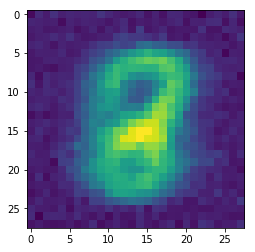

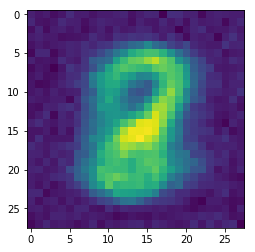

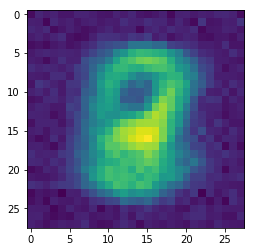

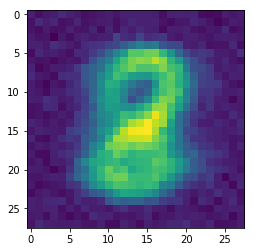

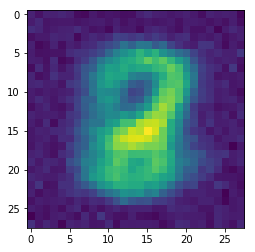

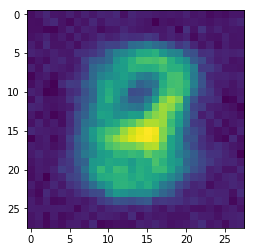

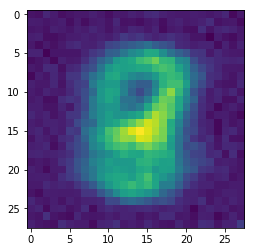

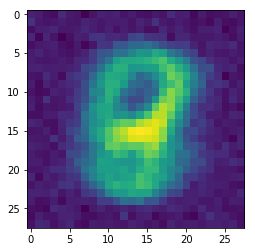

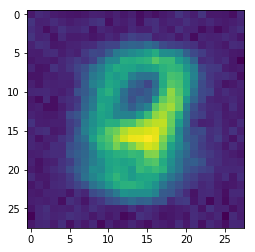

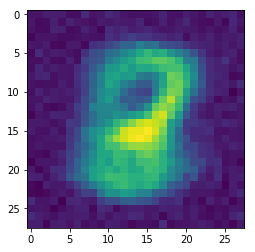

In [242]:
for i in range(10):
    plt.imshow(sigmoid(weights[i]))
    plt.show()

In [179]:
sigmoid(net._V+5)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [113]:
z = np.zeros((10, 1))
z[0] = 1

In [189]:
np.isclose(0, 1e-190, )

True